<a href="https://www.kaggle.com/code/esracum/ai-vs-real-deepfake-detection-using-error-level?scriptVersionId=289996553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

def check_dataset_structure(base_path):
    """
    Veri seti yapısını özetler ve dosya sayılarını raporlar.
    """
    print(f"{'Path':<50} | {'Count':<10}")
    print("-" * 65)
    for root, dirs, files in os.walk(base_path):
        if files:
            # Sadece görüntü dosyalarını say
            images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if images:
                print(f"{root:<50} | {len(images):<10}")

# CIFAKE veri seti yolu (Kaggle ortamı için)
DATASET_DIR = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"
check_dataset_structure(DATASET_DIR)

Path                                               | Count     
-----------------------------------------------------------------
/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE | 10000     
/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL | 10000     
/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE | 50000     
/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL | 50000     


## CIFAKE: Real vs. AI-Generated Image Classification

Yapay zeka tarafından üretilen görsellerin kalitesi arttıkça, dijital güven ve doğruluk sorunu kritik hale gelmektedir. Bu projede, Stable Diffusion v1.4 ile üretilmiş **60,000 sentetik** görüntü ve **60,000 gerçek** (CIFAR-10) görüntüyü içeren **CIFAKE** veri setini analiz ediyoruz. Bilgisayarlı görü teknikleri ve derin öğrenme modelleriyle bir görüntünün gerçek mi yoksa yapay zeka ürünü mü olduğunu yüksek doğrulukla tespit etmeyi hedefliyoruz.

The quality of AI-generated images has rapidly increased, leading to concerns about authenticity. In this project, we analyze the **CIFAKE** dataset, which contains **60,000 synthetic** and **60,000 real** images. We aim to detect AI-generated content using state-of-the-art computer vision techniques.

## Dataset Details: Structure & Composition
### **(Veri Seti Detayları: Yapı ve Kompozisyon)**

CIFAKE veri seti, dijital görüntülerin gerçekliğini test etmek amacıyla akademik standartlarda oluşturulmuştur. Toplamda **120.000** görüntüden oluşan bu veri seti, hem eğitim hem de test aşamaları için dengeli bir yapı sunar.

| Özellik (Feature) | Detaylar (Details) | Kaynak (Source) |
| :--- | :--- | :--- |
| **Sınıflar (Classes)** | REAL (Gerçek) & FAKE (Sentetik) | Bird & Lotfi, 2024 |
| **Eğitim Seti (Training Set)** | 100,000 Görüntü (50k REAL / 50k FAKE) | CIFAKE Dataset |
| **Test Seti (Testing Set)** | 20,000 Görüntü (10k REAL / 10k FAKE) | CIFAKE Dataset |
| **REAL Görüntü Kaynağı** | CIFAR-10 Dataset | Krizhevsky & Hinton, 2009 |
| **FAKE Görüntü Kaynağı** | Stable Diffusion v1.4 | Bird & Lotfi, 2024 |
| **Çözünürlük (Resolution)** | 32x32 Pixels | Optimized for Efficiency |
| **Lisans (License)** | MIT License | CIFAR-10 Standard |



### Key Notes (Kritik Notlar):
* **Balanced Architecture:** Veri setinin sınıflar bazında tam olarak **%50-%50** oranında bölünmüş olması, modelin herhangi bir sınıfa karşı yanlılık (bias) göstermesini engeller.
* **Synthetic Origin:** FAKE (sahte) görüntüler, CIFAR-10 sınıflarının Stable Diffusion v1.4 kullanılarak yeniden üretilmesiyle oluşturulmuştur.
* **Citation Requirement:** Bu veri seti kullanıldığında hem Krizhevsky & Hinton (2009) hem de Bird & Lotfi (2024) kaynaklarına atıf yapılması zorunludur.

## Understanding the Digital Fingerprints
Stable Diffusion tarafından üretilen görüntüler, 32x32 gibi düşük çözünürlüklerde bile belirli matematiksel desenler bırakabilir. Bu bölümde, OpenCV kullanarak görüntülerin "hata seviyelerini" analiz edeceğiz.

* **REAL:** Standart fotoğrafçılık ve sensör verilerinden gelen doğal pikseller.
* **FAKE:** Difüzyon modellerinin (Stable Diffusion) pikselleri yan yana getirme algoritmasından kaynaklanan sentetik dokular.

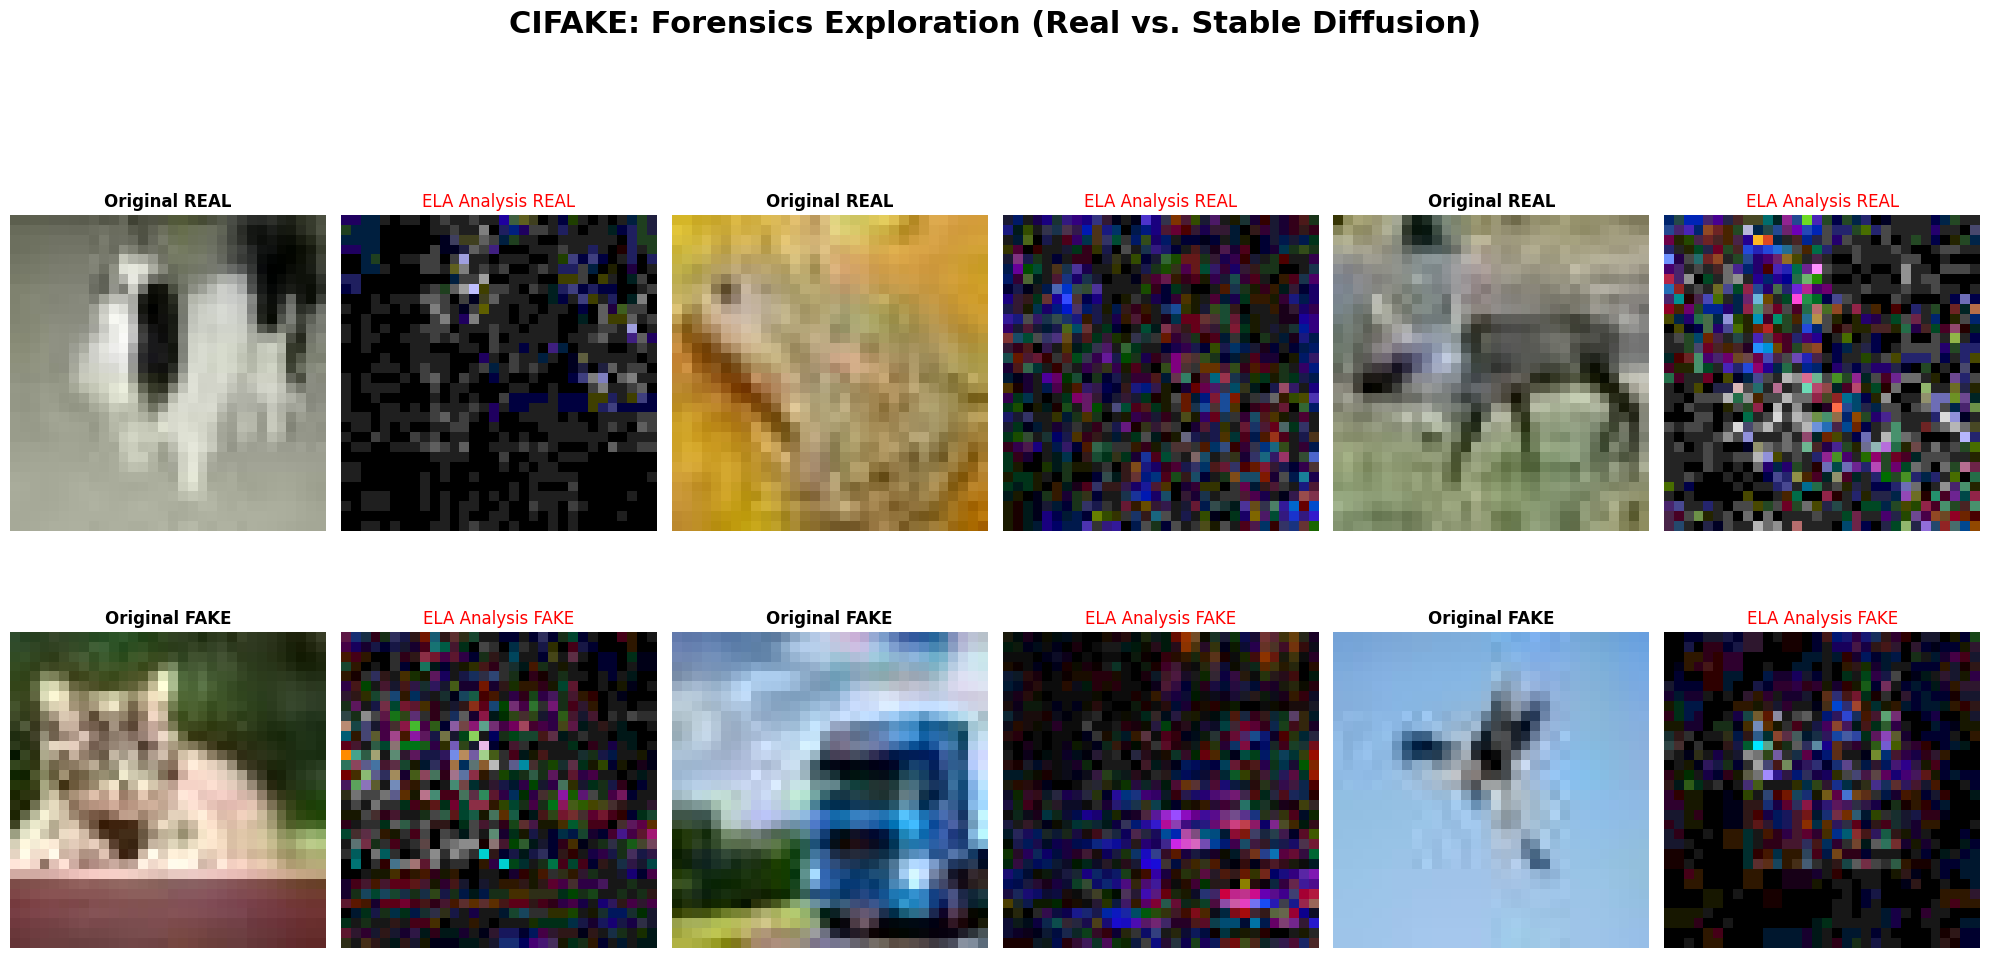

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance, ImageFile
import os
import random

# Bozuk dosya hatasını önlemek için 
ImageFile.LOAD_TRUNCATED_IMAGES = True

def calculate_ela(img_path, quality=90):
    temp_filename = 'temp_ela.jpg'
    original = Image.open(img_path).convert('RGB')
    
    # Geçici kaydet ve farkı al
    original.save(temp_filename, 'JPEG', quality=quality)
    temporary = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(original, temporary)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0: max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    os.remove(temp_filename)
    return ela_image

def plot_samples_with_ela(base_path, n=3):
    classes = ['REAL', 'FAKE'] # CIFAKE sınıf isimleri
    fig, axes = plt.subplots(len(classes), n*2, figsize=(20, 10))
    
    for i, cls in enumerate(classes):
        # CIFAKE yapısı: train/REAL ve train/FAKE
        folder_path = os.path.join(base_path, 'train', cls)
        
        if not os.path.exists(folder_path):
            print(f" Hata: {folder_path} bulunamadı!")
            continue
            
        img_names = random.sample(os.listdir(folder_path), n)
        
        for j, img_name in enumerate(img_names):
            img_path = os.path.join(folder_path, img_name)
            
            # Orijinal Görüntü (32x32 piksel)
            img = Image.open(img_path)
            axes[i, j*2].imshow(img)
            axes[i, j*2].set_title(f"Original {cls}", fontsize=12, fontweight='bold')
            axes[i, j*2].axis('off')
            
            # ELA Analizi
            ela_img = calculate_ela(img_path)
            axes[i, j*2+1].imshow(ela_img)
            axes[i, j*2+1].set_title(f"ELA Analysis {cls}", fontsize=12, color='red')
            axes[i, j*2+1].axis('off')

    plt.suptitle("CIFAKE: Forensics Exploration (Real vs. Stable Diffusion)", fontsize=22, y=1.05, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- ÇALIŞTIRMA BÖLÜMÜ ---
# Kaggle CIFAKE Dataset Ana Yolu
# Fonksiyonu çağırıyoruz (Yorum satırını kaldırdık)
plot_samples_with_ela(DATASET_DIR, n=3)

## Data Preprocessing & Augmentation
(Veri Ön İşleme ve Artırma)
CIFAKE veri setindeki 32x32 boyutundaki görüntüleri modele beslemeden önce normalize etmemiz gerekiyor. Ayrıca modelin yapay zeka tarafından üretilen piksellerdeki farklılıkları daha iyi kavraması için veri artırma tekniklerini sınırlı ama etkili kullanacağız.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Veri Yükleyici (Data Generator)
# CIFAKE dengeli bir set olduğu için karmaşık artırmalara gerek yoktur
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,          # Normalizasyon: 0-255 -> 0-1
    validation_split=0.2     # %20 Validation ayıralım
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 2. Akışı Başlatma
train_gen = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

2026-01-04 13:18:28.394540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767532708.584075      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767532708.636756      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767532709.087601      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767532709.087634      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767532709.087637      55 computation_placer.cc:177] computation placer alr

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## CNN Model Architecture

In [4]:
def build_cifake_model():
    model = models.Sequential([
        # 1. Blok
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # 2. Blok
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Tam Bağlantılı Katmanlar
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid') # Binary Classification: REAL vs FAKE
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

cifake_model = build_cifake_model()
cifake_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1767532763.634548      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767532763.638422      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,393 (2.26 MB)

 Trainable params: 590,753 (2.25 MB)

 Non-trainable params: 640 (2.50 KB)

### 🧠 Model Strategy: Custom CNN with Regularization
Stable Diffusion (FAKE) ve CIFAR-10 (REAL) görüntüleri arasındaki farklar, piksellerdeki çok ince dokularda gizlidir. 32x32 çözünürlük için büyük modeller yerine, 3 ana bloktan oluşan bir **CNN** tercih ettik. **BatchNormalization** eğitim hızını artırırken, **Dropout** katmanları 100.000 görüntülük eğitim setinde modelin ezberlemesini (overfitting) engellemektedir.

## Model Training (Eğitim)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cifake_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1767532786.515507     140 service.cc:152] XLA service 0x79fb38016710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767532786.515568     140 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767532786.515574     140 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767532787.236483     140 cuda_dnn.cc:529] Loaded cuDNN version 91002


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 3:22:53 10s/step - accuracy: 0.4688 - loss: 1.0088

I0000 00:00:1767532792.805149     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 731s 577ms/step - accuracy: 0.8626 - loss: 0.3286 - val_accuracy: 0.9070 - val_loss: 0.2250
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 132s 105ms/step - accuracy: 0.9330 - loss: 0.1749 - val_accuracy: 0.9254 - val_loss: 0.1855
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - accuracy: 0.9398 - loss: 0.1583 - val_accuracy: 0.9123 - val_loss: 0.2168
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.9454 - loss: 0.1422 - val_accuracy: 0.9424 - val_loss: 0.1486
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.9502 - loss: 0.1300 - val_accuracy: 0.9551 - val_loss: 0.1192
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 100s 80ms/step - accuracy: 0.9525 - loss: 0.1237 - val_accuracy: 0.9560 - val_loss: 0.1158
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.9565 - loss: 0.1142 - val_accuracy: 0.9592 - val_loss: 0.1133
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.9598 - loss:

## Results & Performance Analysis


### Eğitim Grafikleri (History Plot)

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc', marker='o')
    plt.plot(val_acc, label='Val Acc', marker='x')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Val Loss', marker='x')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

plot_training(history)

### Confusion Matrix (Hata Matrisi)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test verisiyle tahmin alalım
# Not: test_gen'i daha önce tanımladığımız test_datagen ile oluşturmalısın
test_gen = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=(32, 32),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

y_pred_prob = cifake_model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CIFAKE Detection')
plt.show()

print(classification_report(y_true, y_pred, target_names=['REAL', 'FAKE']))

### Grad-CAM (Isı Haritası)

In [ ]:
import tensorflow as tf

def get_grad_cam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Örnek bir FAKE resim üzerinde deneyelim
# Not: Modelindeki son Conv2D katmanının adını model.summary()'den kontrol et (Genelde 'conv2d_x' şeklindedir)
last_conv_layer = [layer.name for layer in cifake_model.layers if "conv2d" in layer.name][-1]
img, label = next(test_gen)
heatmap = get_grad_cam(cifake_model, img[0:1], last_conv_layer)

plt.matshow(heatmap)
plt.title("Model's Focus Area (Heatmap)")
plt.show()